<h4>ChatGPT Internal Source Consistency Analysis</h4>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "src")))
from data import get_chatgpt_df
from metrics import syntactic_overlap, extrapolated_rbo
from plots import boxplot, heatmaps

In [2]:
OVERLAP_FUNCTION = syntactic_overlap

<h4>Dataset: ChatGPT</h4>

In [3]:
chatgpt_df = get_chatgpt_df()
chatgpt_df

,query,product,market_type,query_level,response_text,sources_cited,sources_additional,sources_all,domains_cited,domains_additional,domains_all,recommended_products
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,[There’s no one “best” smartphone that’s perfe...,[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.tomsguide.com/phones/android-pho...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, forbes.com], [tomsguide.com],...","[[reddit.com, tomsguide.com, techrepublic.com,...","[[tomsguide.com, forbes.com, reddit.com, techr...","[[Apple iPhone 17 Pro Max, Samsung Galaxy S25 ..."
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,"[There’s no one “best” smartphone under $1,000...",[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.androidcentral.com/best-android-...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, phonearena.com, wired.com], [...","[[reddit.com, theverge.com, techadvisor.com, w...","[[tomsguide.com, phonearena.com, wired.com, re...","[[Samsung Galaxy S25, Samsung Galaxy S25+, App..."
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,"[There’s no one-size-fits-all “best” phone, be...",[[https://www.techradar.com/news/best-cameraph...,[[https://coffeechoice.org/en/best-smartphones...,[[https://www.techradar.com/news/best-cameraph...,"[[tomsguide.com, techradar.com], [abdgadgets.c...","[[reddit.com, tomsguide.com, stuff.tv, techadv...","[[tomsguide.com, techradar.com, reddit.com, st...","[[Apple iPhone 16 Pro, Samsung Galaxy S25 Ultr..."
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,[That’s a great question — the “best” depends ...,[[https://www.androidcentral.com/phones/oneplu...,[[https://www.techadvisor.com/article/723383/b...,[[https://www.androidcentral.com/phones/oneplu...,"[[androidcentral.com, tomsguide.com, phonearen...","[[tomsguide.com, wired.com, co.uk, 9to5google....","[[androidcentral.com, tomsguide.com, phonearen...","[[OnePlus 13, Samsung Galaxy S25, Google Pixel..."
4,What is the best laptop?,Laptop,Commodity / Saturated,General,[There’s no one-size-fits-all “best laptop” — ...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.bleepingcomputer.com/forums/t/81...,[[https://www.pcworld.com/article/436674/best-...,"[[windowscentral.com, rtings.com, pcworld.com,...","[[reddit.com, bestbuy.com, windowscentral.com,...","[[windowscentral.com, rtings.com, pcworld.com,...","[[Lenovo Yoga 9i 2-in-1 Aura Edition, Lenovo T..."
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,[There’s no one-size-fits-all “best” laptop un...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, wired.com], [tomshardware....","[[reddit.com, tomshardware.com, pcworld.com, y...","[[tomshardware.com, wired.com, reddit.com, pcw...","[[HP Victus 16, Asus Zenbook S 16, MacBook Air..."
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,[“Best” depends a lot on what you plan to use ...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, techradar.com], [tomshardw...","[[reddit.com, tomsguide.com, tomshardware.com,...","[[tomshardware.com, techradar.com, reddit.com,...","[[HP Victus 16, Apple MacBook Air 15″ (M4), HP..."
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,[“Best” always depends a bit on what you value...,[[https://www.ultrabookreview.com/2071-best-ga...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.ultrabookreview.com/2071-best-

<h4>Mean Internal Source Overlap (MISO) - Definition & Implementation</h4> 
For each query $q$, ChatGPT produces three source sets 
$S_q^{\mathrm{G}} = \{s^{\mathrm{G}}_{q1}, s^{\mathrm{G}}_{q2}, s^{\mathrm{G}}_{q3}\}$. 
To measure internal consistency in the sources returned by ChatGPT, we compute the syntactic overlap between all unordered pairs of source sets.

Let $\mathcal{C} = \{(i,j) \mid 1 \le i < j \le |S_q^{\mathrm{G}}|\} \quad \Rightarrow \quad |\mathcal{C}| = {{|S_q^{\mathrm{G}}|}\choose{2}}$

Then, the mean internal source overlap is defined as:
$$\mathrm{MISO}(q) =
\frac{1}{|\mathcal{C}|}
\sum_{(i,j)\in \mathcal{C}}
\mathrm{overlap}_{syntactic}(s^{\mathrm{G}}_{qi}, s^{\mathrm{G}}_{qj})$$


In [4]:
def calc_miso(chatgpt_df, chatgpt_sources, overlap_function):
    from itertools import combinations
    
    mipo_results = []

    for _, row in chatgpt_df.iterrows():
        row_list = row[chatgpt_sources]
        pairwise_scores = []

        for c in combinations(row_list, 2):
            score = overlap_function(c[0], c[1])
            pairwise_scores.append(score)

        syntactic_mean = np.mean(pairwise_scores)
        syntactic_var = np.var(pairwise_scores, ddof = 0)
        syntactic_std = np.sqrt(syntactic_var)

        mipo_results.append({
            "query": row["query"],
            "product": row["product"],
            "market_type": row["market_type"],
            "query_level": row["query_level"],
            "miso_mean": syntactic_mean,
            "miso_var": syntactic_var,
            "miso_std": syntactic_std
        })

    return pd.DataFrame(mipo_results)

<h4>Mean Internal Source Overlap - Cited Sources Analysis</h4>

In [5]:
miso_df_cs = calc_miso(chatgpt_df, chatgpt_sources = "sources_cited", overlap_function = OVERLAP_FUNCTION)
miso_df_cs.to_csv("miso_df.csv")
miso_df_cs

,query,product,market_type,query_level,miso_mean,miso_var,miso_std
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,1.000000,0.000000,0.000000
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,0.250000,0.125000,0.353553
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,0.333333,0.222222,0.471405
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,0.000000,0.000000,0.000000
4,What is the best laptop?,Laptop,Commodity / Saturated,General,0.666667,0.000000,0.000000
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,0.500000,0.000000,0.000000
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,0.833333,0.055556,0.235702
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,0.166667,0.055556,0.235702
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,0.666667,0.013889,0.117851
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,1.000000,0.000000,0.000000


<h4>Mean Internal Source Overlap - Analysis (Cited Sources)</h4>

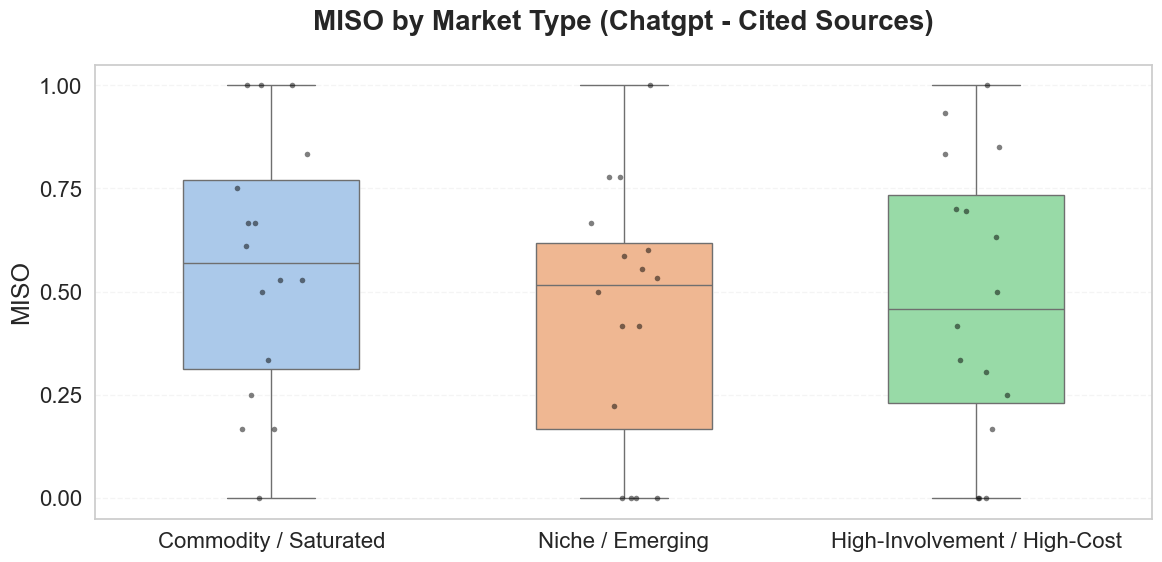

In [6]:
miso_cs_cs = miso_df_cs[miso_df_cs["market_type"] == "Commodity / Saturated"]
miso_ne_cs = miso_df_cs[miso_df_cs["market_type"] == "Niche / Emerging"]
miso_hh_cs = miso_df_cs[miso_df_cs["market_type"] == "High-Involvement / High-Cost"]

plot_df_cs = pd.DataFrame({
    "MISO": pd.concat([
        miso_cs_cs["miso_mean"],
        miso_ne_cs["miso_mean"],
        miso_hh_cs["miso_mean"],
    ], ignore_index = True),
    "Market Type": (
        ["Commodity / Saturated"] * len(miso_cs_cs)
        + ["Niche / Emerging"] * len(miso_ne_cs)
        + ["High-Involvement / High-Cost"] * len(miso_hh_cs)
    )
})

boxplot(
    df = plot_df_cs,
    x_col = "Market Type",
    y_col = "MISO",
    order = ["Commodity / Saturated", "Niche / Emerging", "High-Involvement / High-Cost"],
    title = "MISO by Market Type (Chatgpt - Cited Sources)",
    xlabel = "",
    ylabel = "MISO"
)

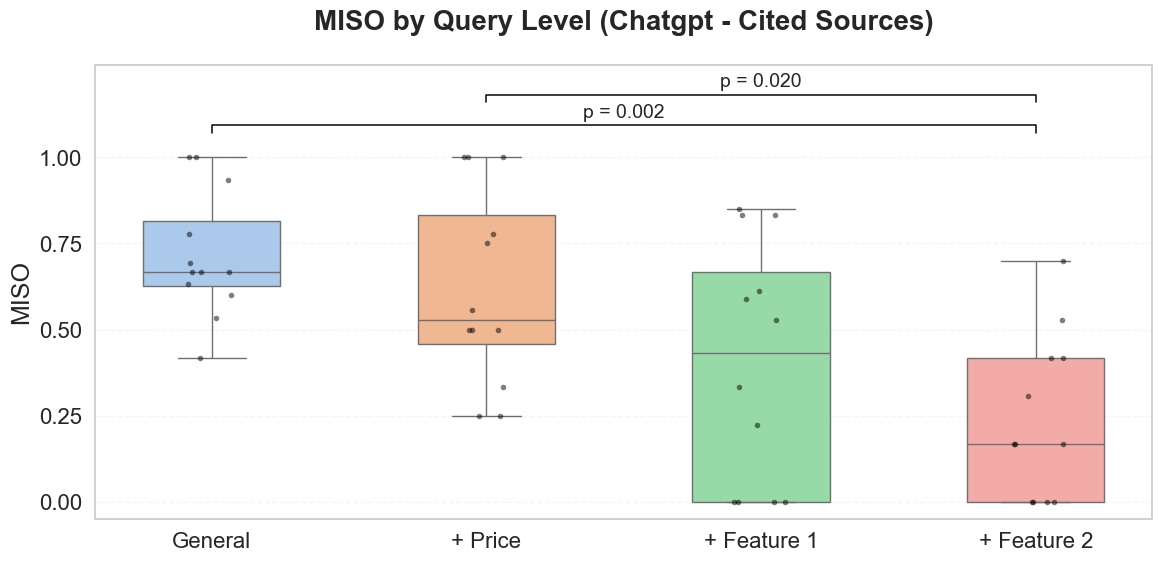

In [7]:
miso_g_cs = miso_df_cs[miso_df_cs["query_level"] == "General"]
miso_gp_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price"]
miso_gpf_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price & Feature"]
miso_gpff_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price & Feature & Feature"]

plot_df_cs = pd.DataFrame({
    "MISO": pd.concat([
        miso_g_cs["miso_mean"],
        miso_gp_cs["miso_mean"],
        miso_gpf_cs["miso_mean"],
        miso_gpff_cs["miso_mean"]
    ], ignore_index = True),
    "Query Level": (
        ["General"] * len(miso_g_cs)
        + ["+ Price"] * len(miso_gp_cs)
        + ["+ Feature 1"] * len(miso_gpf_cs)
        + ["+ Feature 2"] * len(miso_gpff_cs)
    )
})

boxplot(
    df = plot_df_cs,
    x_col = "Query Level",
    y_col = "MISO",
    order = ["General", "+ Price", "+ Feature 1", "+ Feature 2"],
    title = "MISO by Query Level (Chatgpt - Cited Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<br />

<h4>Mean Internal Source Overlap - Analyis (All Sources)</h4>

In [8]:
miso_df_as = calc_miso(chatgpt_df, chatgpt_sources = "sources_all", overlap_function = OVERLAP_FUNCTION)
miso_df_as

,query,product,market_type,query_level,miso_mean,miso_var,miso_std
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,0.933333,0.002222,0.047140
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,0.788235,0.012129,0.110130
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,0.827778,0.003025,0.054997
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,0.733333,0.035556,0.188562
4,What is the best laptop?,Laptop,Commodity / Saturated,General,0.848485,0.001837,0.042855
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,0.358586,0.040455,0.201134
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,0.941919,0.001696,0.041186
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,0.361111,0.145247,0.381113
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,0.866667,0.035556,0.188562
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,0.777778,0.024691,0.157135


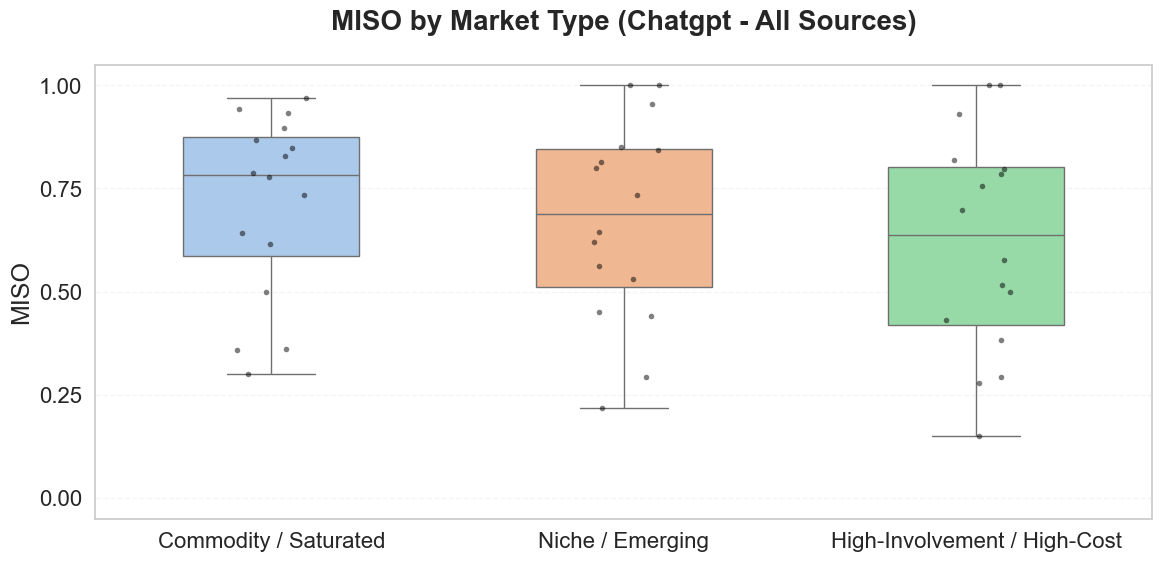

In [9]:
miso_cs_as = miso_df_as[miso_df_as["market_type"] == "Commodity / Saturated"]
miso_ne_as = miso_df_as[miso_df_as["market_type"] == "Niche / Emerging"]
miso_hh_as = miso_df_as[miso_df_as["market_type"] == "High-Involvement / High-Cost"]

plot_df_as = pd.DataFrame({
    "MISO": pd.concat([
        miso_cs_as["miso_mean"],
        miso_ne_as["miso_mean"],
        miso_hh_as["miso_mean"],
    ], ignore_index = True),
    "Market Type": (
        ["Commodity / Saturated"] * len(miso_cs_as)
        + ["Niche / Emerging"] * len(miso_ne_as)
        + ["High-Involvement / High-Cost"] * len(miso_hh_as)
    )
})

boxplot(
    df = plot_df_as,
    x_col = "Market Type",
    y_col = "MISO",
    order = ["Commodity / Saturated", "Niche / Emerging", "High-Involvement / High-Cost"],
    title = "MISO by Market Type (Chatgpt - All Sources)",
    xlabel = "",
    ylabel = "MISO"
)

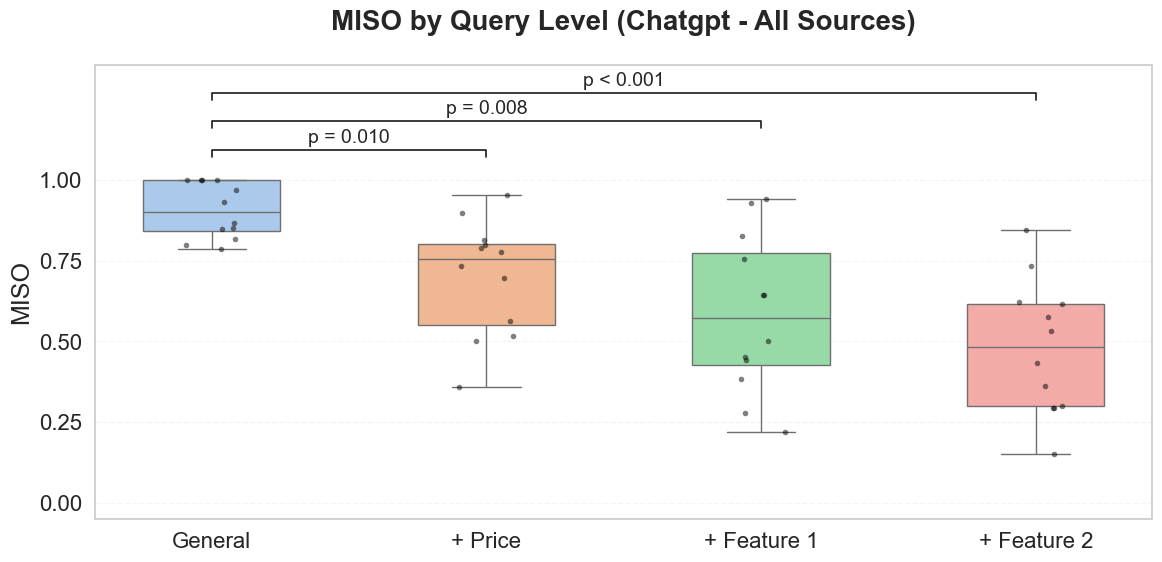

In [10]:
miso_g_as = miso_df_as[miso_df_as["query_level"] == "General"]
miso_gp_as = miso_df_as[miso_df_as["query_level"] == "General & Price"]
miso_gpf_as = miso_df_as[miso_df_as["query_level"] == "General & Price & Feature"]
miso_gpff_as = miso_df_as[miso_df_as["query_level"] == "General & Price & Feature & Feature"]

plot_df_as = pd.DataFrame({
    "MISO": pd.concat([
        miso_g_as["miso_mean"],
        miso_gp_as["miso_mean"],
        miso_gpf_as["miso_mean"],
        miso_gpff_as["miso_mean"]
    ], ignore_index = True),
    "Query Level": (
        ["General"] * len(miso_g_as)
        + ["+ Price"] * len(miso_gp_as)
        + ["+ Feature 1"] * len(miso_gpf_as)
        + ["+ Feature 2"] * len(miso_gpff_as)
    )
})

boxplot(
    df = plot_df_as,
    x_col = "Query Level",
    y_col = "MISO",
    order = ["General", "+ Price", "+ Feature 1", "+ Feature 2"],
    title = "MISO by Query Level (Chatgpt - All Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<br />

<h4>Cross-Query Mean Internal Source Overlap (Allpairs) – Definition &amp; Implementation</h4> 
For each query $q$, ChatGPT returns three source sets  
$S_q^{\mathrm{G}} = \{s^{\mathrm{G}}_{q1}, s^{\mathrm{G}}_{q2}, s^{\mathrm{G}}_{q3}\}$. 
To compare internal consistency across different queries, we compute the mean syntactic overlap between all source sets from query $i$ and query $j$. Thus, for any pair of queries $(i,j)$, the cross-query mean internal source overlap is defined as:
$$\mathrm{CQMISO}[i,j] =
\frac{1}{|S_i^{\mathrm{G}}| \cdot |S_j^{\mathrm{G}}|}
\sum_{k=1}^{|S_i^{\mathrm{G}}|}
\sum_{l=1}^{|S_j^{\mathrm{G}}|}
\mathrm{overlap}_{syntactic}(s^{\mathrm{G}}_{ik}, s^{\mathrm{G}}_{jl})$$

In [11]:
def calc_cqmiso_allpairs(chatgpt_df, source_col, overlap_function, filter_col = None):
    
    n = len(chatgpt_df)
    cqmiso_matrix = np.full((n, n), 0, dtype = float)
    source_lists = chatgpt_df[source_col].tolist()
    
    # filter
    filter_values = chatgpt_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            pairwise_overlaps = [
                overlap_function(a, b)
                for a in source_lists[i]
                for b in source_lists[j]
            ]
            cqmiso = np.mean(pairwise_overlaps) if pairwise_overlaps else np.nan
            cqmiso_matrix[i, j] = cqmiso
            cqmiso_matrix[j, i] = cqmiso
    
    return pd.DataFrame(cqmiso_matrix, index = chatgpt_df["query"], columns = chatgpt_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

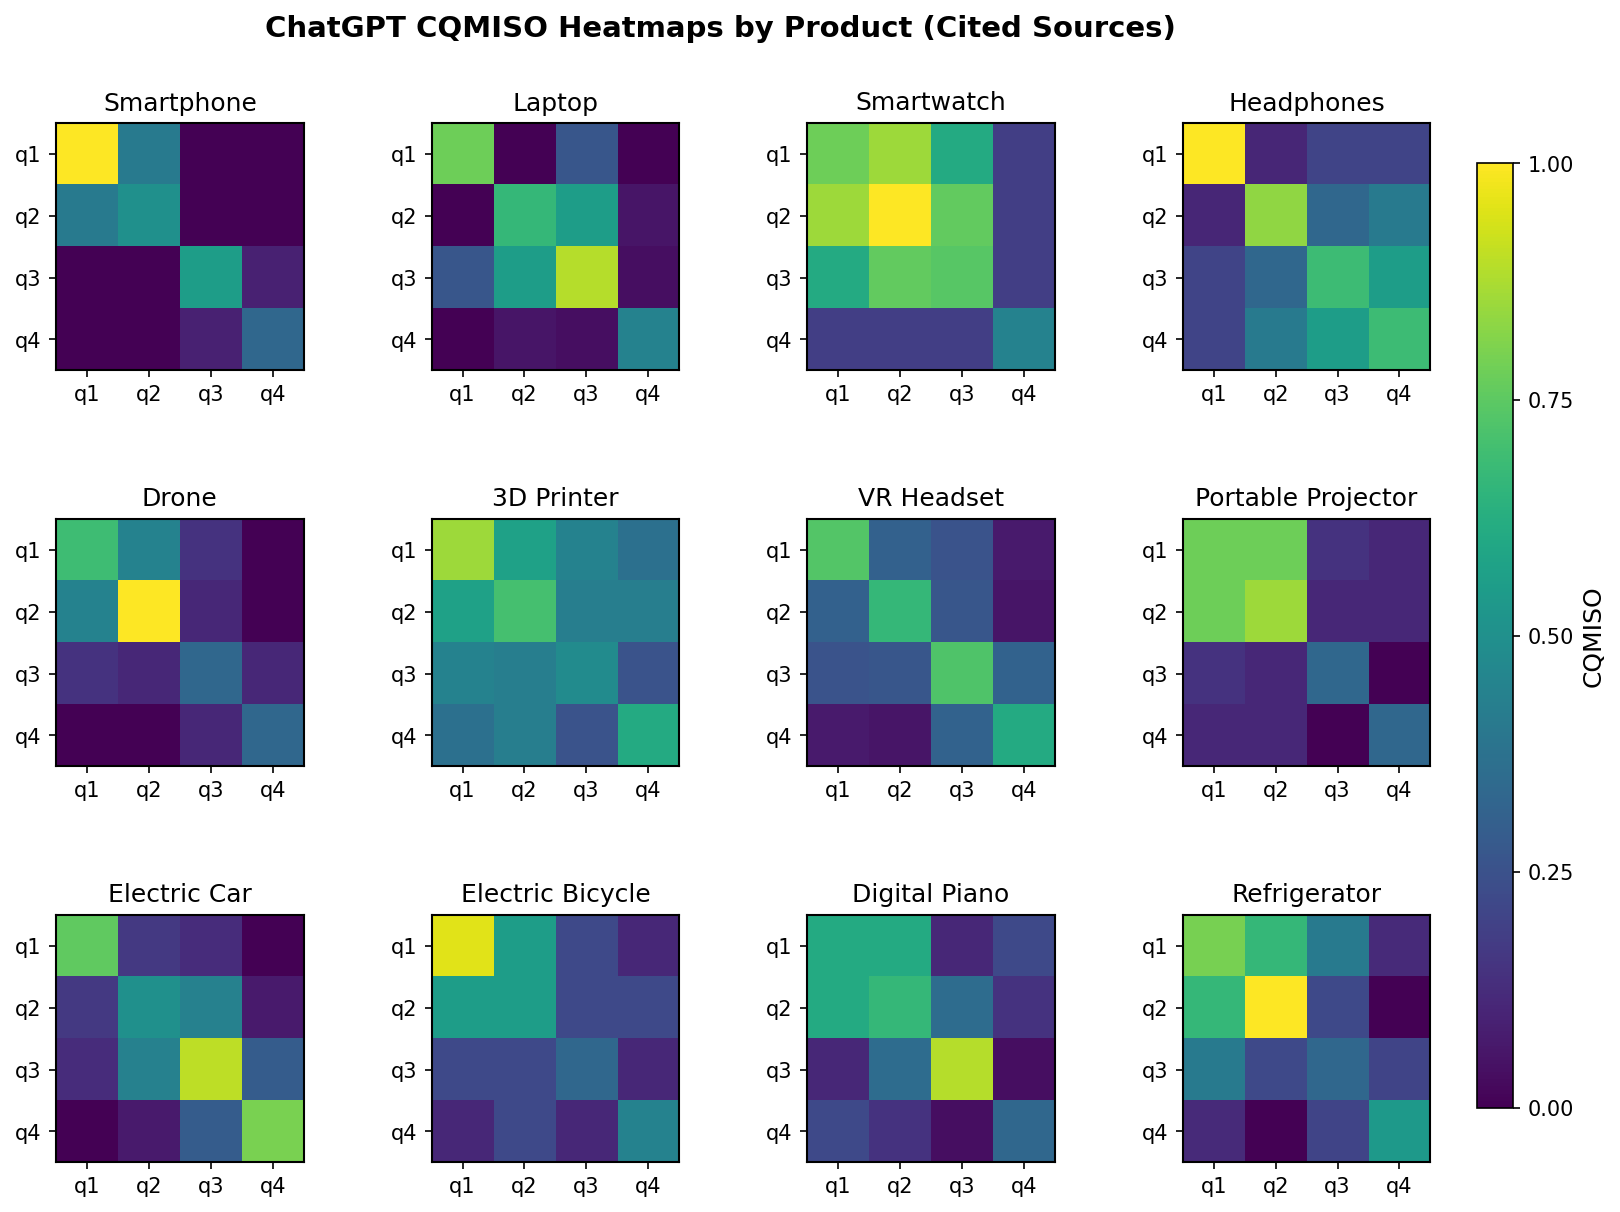

In [12]:
cqmiso_matrix_p_cs_a = calc_cqmiso_allpairs(chatgpt_df, source_col = "sources_cited", overlap_function = OVERLAP_FUNCTION, filter_col = "product")
heatmaps(cqmiso_matrix_p_cs_a, chatgpt_df, filter_col = "product", title = "ChatGPT CQMISO Heatmaps by Product (Cited Sources)", colorbar_label = "CQMISO")

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

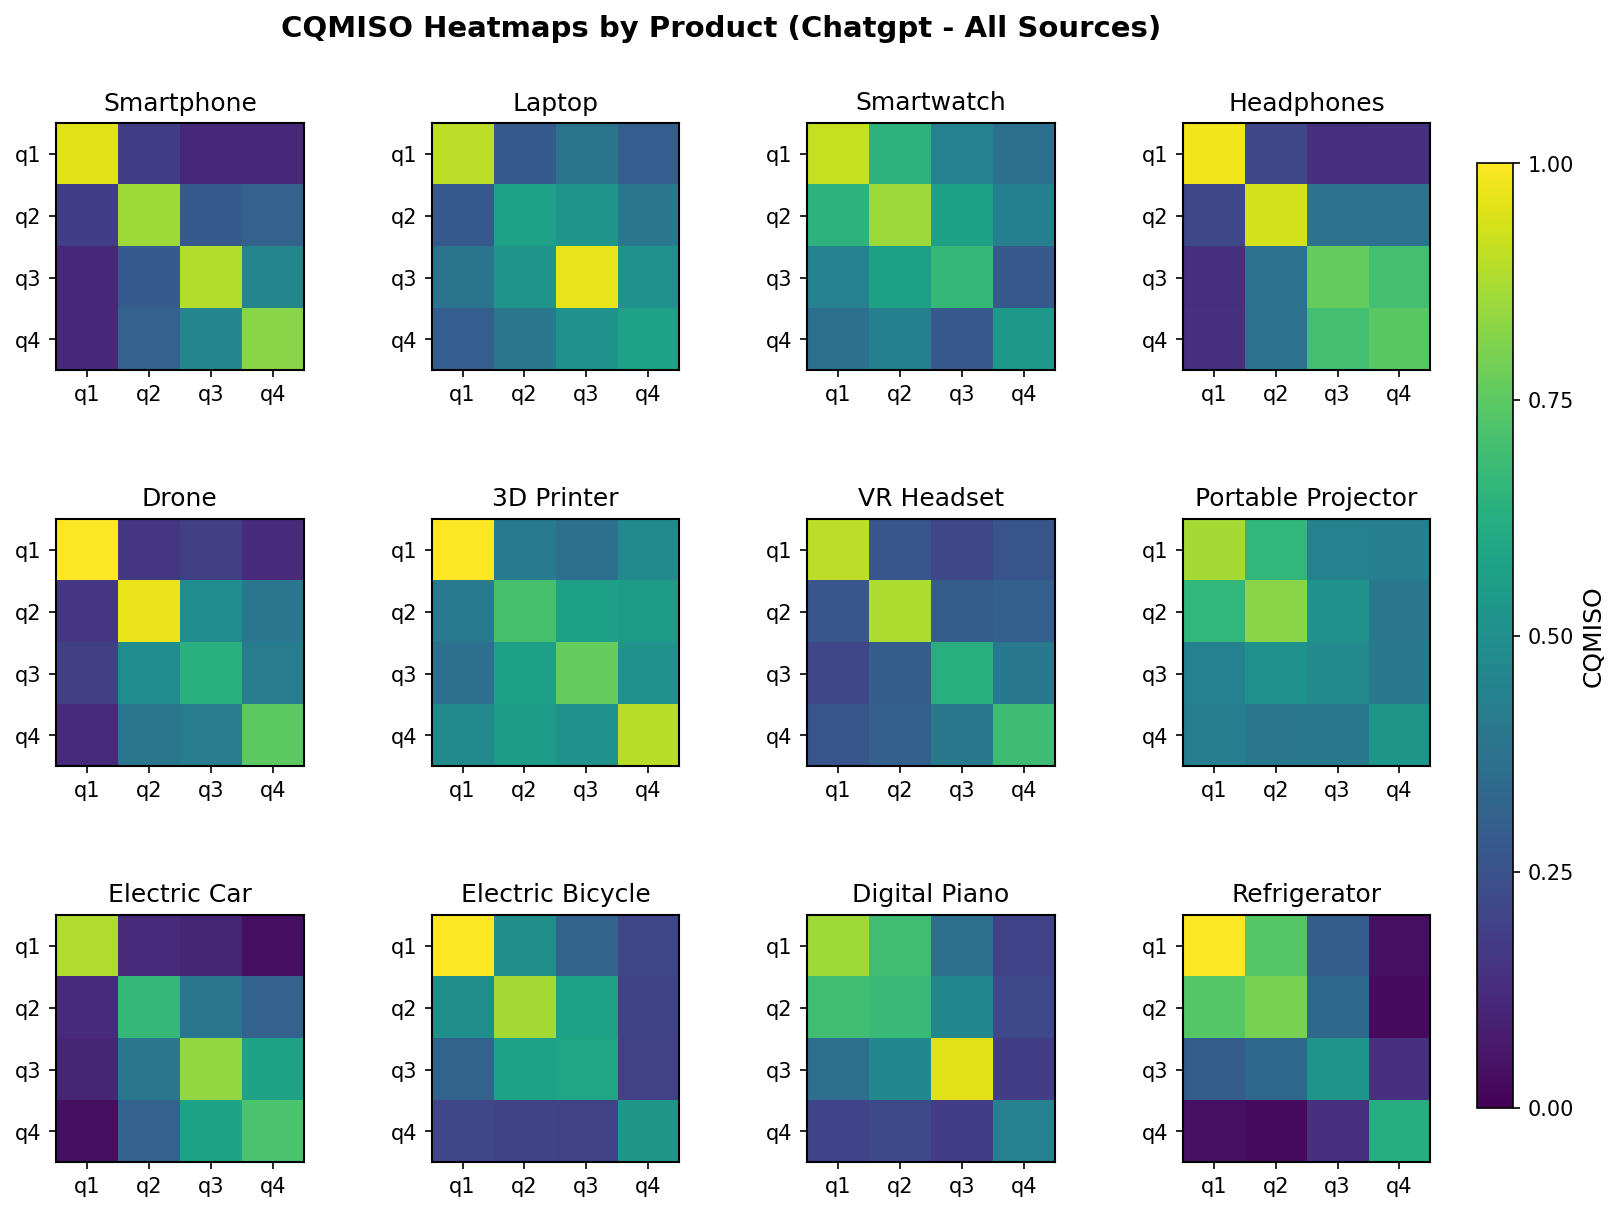

In [13]:
cqmiso_matrix_p_ca_a = calc_cqmiso_allpairs(chatgpt_df, source_col = "sources_all", overlap_function = OVERLAP_FUNCTION, filter_col = "product")
heatmaps(cqmiso_matrix_p_ca_a, chatgpt_df, filter_col = "product", title = "CQMISO Heatmaps by Product (Chatgpt - All Sources)", colorbar_label = "CQMISO")

<br />